<a href="https://colab.research.google.com/github/nlionf/projects/blob/main/Running_Log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

If you were to go for a run right now, you would quickly be able to tell me if you're feeling 'fit' or 'out of shape'. The problem is that our own subjective feeling can vary significantly from day to day, often because of a simple mood swing. Can we estimate our true level of fitness in a more objective fashion?

One solution is to track your progress over time, writing down your results at the end of each training session. This allows you to then go back and compare your current results with your past ones. Nowadays, there are plenty of apps designed to do this for you, in addition to smart watches that can even measure your heart's BPM. However, with all this data now available, tracking your fitness can quickly become very confusing.

**Jeffrey Braun**, a running and data enthusiast, tracked his training over two years and was kind enough to upload it to Kaggle for everyone to use. He collected the data via his Garmin GPS watch designed to track everything related to running - including distance, elevation, pace, heartrate, calories burned and more. In the dataset's description, Mr. Braun wrote that he would be interested to see if someone could estimate his "fitness" as a function of time. This is what I have attempted to do.

With the data in hand, I tried to find creative ways to estimate Mr. Braun's underlying fitness level -- aside from simply looking at how far and how fast he can run. Additionally, being a fitness enthusiast myself, I was interested to see the relation between training intensity and fitness. Training intensity is very difficult to get right -- too low an intensity and you might not make much progress, too high an intensity and you risk undermining your training due to insufficient recovery.

For more information on the dataset - visit https://www.kaggle.com/datasets/jeffreybraun/running-log-insight

# Setup

In [59]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.dates as mdates

In [60]:
#@title 
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [61]:
#@title 
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'spherical-arc-359810'
!gcloud config set project {project_id}

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id)

Updated property [core/project].


In [62]:
def run_query(query_job):
  results = query_job.result()
  return results.to_dataframe()

First we'll look at the total amount of entries in the log of each activity type:

In [63]:
query_job = client.query(
    """
    SELECT Activity_Type, COUNT(*) AS row_count
    FROM `spherical-arc-359810.running_analysis_proj.running_log`
    GROUP BY Activity_Type
    """
)
run_query(query_job)

,Activity_Type,row_count
0,Running,672
1,Cardio,7
2,Treadmill Running,10


The 7 *Cardio* rows are irrelevant to our analysis. *Treadmill Running* will be considered identical to traditional running.

In [64]:
# Selecting all relevant columns while excluding cardio and rows where the distance is null
query_job = client.query(
    """
    SELECT Activity_Type, Date, Distance, Time, Calories, Avg_HR, Max_HR, Avg_Run_Cadence, Max_Run_Cadence,
           Avg_Pace, Best_Pace, Elev_Gain, Elev_Loss, Avg_Stride_Length
    FROM `spherical-arc-359810.running_analysis_proj.running_log`
    WHERE Distance != 0 AND Activity_Type != 'Cardio';
    """
)
data = run_query(query_job)

# First look at the data

Quick overview of our selected columns:

In [65]:
data.tail()

,Activity_Type,Date,Distance,Time,Calories,Avg_HR,Max_HR,Avg_Run_Cadence,Max_Run_Cadence,Avg_Pace,Best_Pace,Elev_Gain,Elev_Loss,Avg_Stride_Length
676,Running,0018-09-23 09:12:00+00:00,17.25,1:53:00,818.0,131.0,158.0,178.0,194.0,6:33,4:46,1041.0,1055.0,1.38
677,Running,0018-08-26 09:26:00+00:00,17.09,1:54:54,1492.0,149.0,182.0,176.0,194.0,6:43,4:56,685.0,690.0,1.36
678,Running,0019-03-31 09:12:00+00:00,17.08,1:57:51,1026.0,140.0,177.0,182.0,196.0,6:54,4:59,985.0,979.0,1.29
679,Running,0019-03-24 10:48:00+00:00,17.50,1:59:19,1117.0,142.0,165.0,180.0,218.0,6:49,5:09,971.0,978.0,1.32
680,Running,2019-03-10 10:58:00+00:00,18.01,1:58:32,1220.0,149.0,180.0,176.0,188.0,6:35,1:36,506.0,505.0,1.38


In [66]:
data.nunique()  # number of unique values per column

Activity_Type          2
Date                 681
Distance             353
Time                 635
Calories             475
Avg_HR                73
Max_HR                76
Avg_Run_Cadence       21
Max_Run_Cadence       29
Avg_Pace             204
Best_Pace            247
Elev_Gain            383
Elev_Loss            379
Avg_Stride_Length     86
dtype: int64

In [67]:
data.isna().sum()  # number of NA values per column

Activity_Type         0
Date                  0
Distance              0
Time                  0
Calories             26
Avg_HR               26
Max_HR               26
Avg_Run_Cadence      27
Max_Run_Cadence      27
Avg_Pace              0
Best_Pace            26
Elev_Gain            45
Elev_Loss            43
Avg_Stride_Length     0
dtype: int64

The following columns must be converted from strings to numerical values:

In [68]:
data[["Time", "Avg_Pace", "Best_Pace"]].tail()

,Time,Avg_Pace,Best_Pace
676,1:53:00,6:33,4:46
677,1:54:54,6:43,4:56
678,1:57:51,6:54,4:59
679,1:59:19,6:49,5:09
680,1:58:32,6:35,1:36


We'll measure everything in minutes to keep things simple.

In [69]:
def to_minutes(time):
  """ Converts hrs:mins:secs (or mins:secs.millisecs) to minutes (float) """
  res = 0
  if not isinstance(time, list):
    return time
  if len(time) == 2:
    res += float(time[0])       # Minutes
    res += float(time[1]) / 60  # Seconds
  if len(time) == 3:
    res += float(time[0]) * 60  # Hours
    res += float(time[1])       # Minutes
    res += float(time[2]) / 60  # Seconds
  return float(res)

def time_to_mins(time_col):
  """ Takes a column and applies the to_minutes function to it """
  temp = time_col
  temp = temp.apply(lambda x: x.split(":") if isinstance(x, str) else x)  # splitting timestamp into hours, minutes and seconds.
  temp = temp.apply(to_minutes)
  return temp

In [70]:
data["Time"] = time_to_mins(data["Time"])
data["Avg_Pace"] = time_to_mins(data["Avg_Pace"])
data["Best_Pace"] = time_to_mins(data["Best_Pace"])

The running log spans the years 2018-2020, but some of the timestamps have the years recorded in only 2 digits instead of 4 (i.e. 19 instead of 2019).

In [71]:
def fix_years(dt):
  """
  Replaces 2 digit year stamps with 4 digit ones.
  """
  temp = dt
  if dt.year == 18:
    temp = dt.replace(year=2018)
  if dt.year == 19:
    temp = dt.replace(year=2019)
  if dt.year == 20:
    temp = dt.replace(year=2020)
  return temp

data["Date"] = data["Date"].apply(fix_years)
data = data.set_index("Date")

# Running volume and intensity

## First visualizations

We'll begin with a simple scatter plot of every individual run recorded along with its distance (in miles).

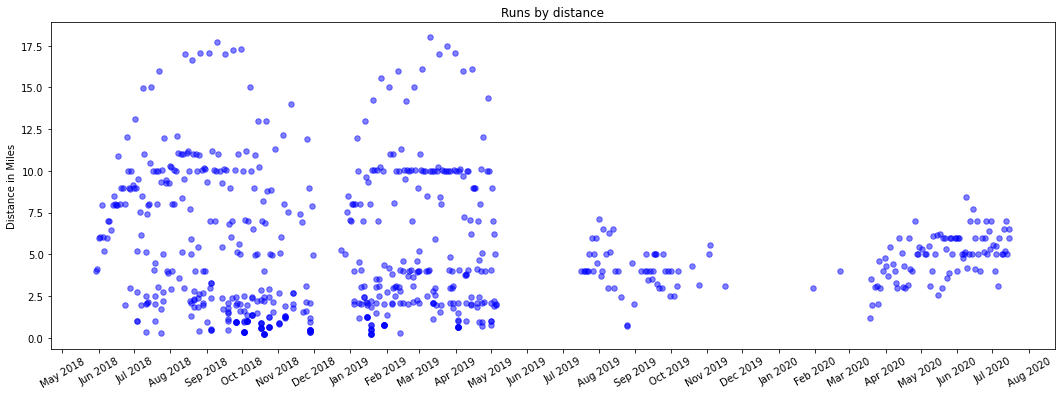

In [72]:
#@title Runs by distance
fig, ax = plt.subplots(figsize=(18, 6))
plt.title('Runs by distance')
plt.ylabel('Distance in Miles')
plt.scatter(data.index, data["Distance"], label='Distance', c='blue', s=30, alpha=0.5)
ax.xaxis.set_major_locator(mdates.MonthLocator())
fmt = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(fmt)
plt.setp(ax.get_xticklabels(), rotation=30);

We can clearly separate the log into four distinct periods, with the first two being much denser than the last two.

This makes sense considering Mr. Braun's words: "*I ran competitively in college and took a break when I graduated in 2019*"

To get a better grasp of the training progress made, we'll zoom in on each period individually.

Additionally, we'll check to see if there are significant differences in the data when comparing short, medium and long distance runs.

For this purpose we will use scikit's KMeans classification algorithm to group our runs by distance:

In [73]:
#@title 
from sklearn.cluster import KMeans
""" Using scikit's KMeans algorithm to separate the Distance variable into 3 categories: long, medium and short. """

distance_kmeans = np.array(data["Distance"]).reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=0) 
kmeans.fit(distance_kmeans)

data["Category"] = kmeans.labels_

def categorize(labels):
  if labels == 0:
    return 'Short'
  elif labels == 1:
    return 'Medium'
  elif labels == 2:
    return 'Long'

data["Category"] = data["Category"].apply(categorize)

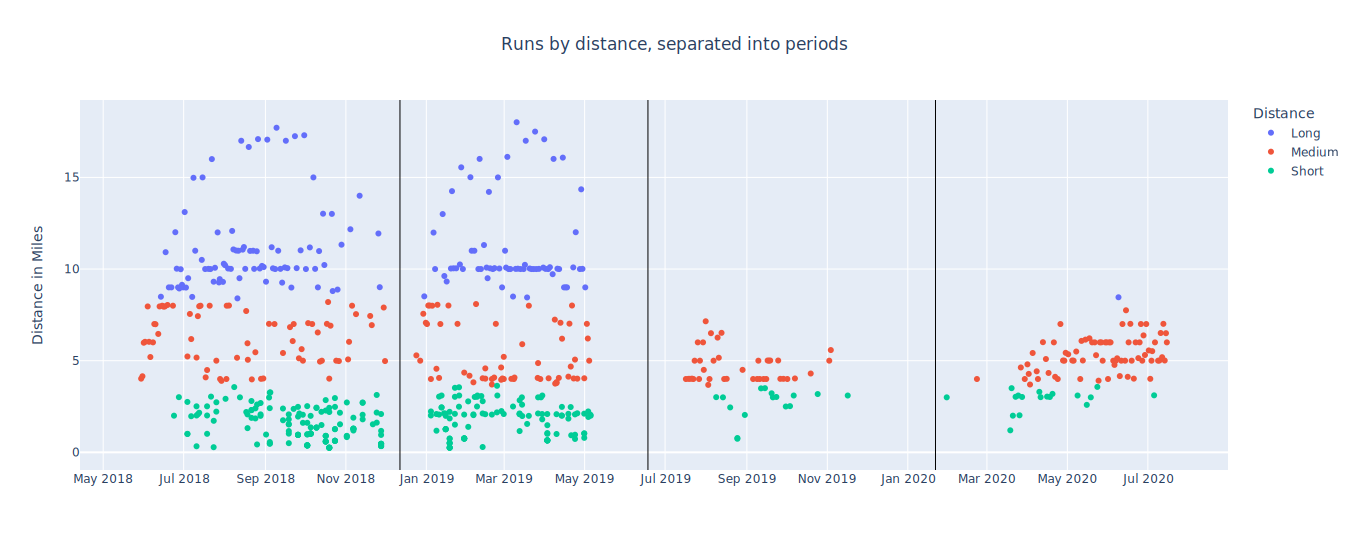

In [74]:
#@title Runs by distance, separated into periods
import plotly.express as px
fig = px.scatter(data, x=data.index, y="Distance",
                 title="Runs by distance, separated into periods",
                 color="Category",
                 labels={"Category" : "Distance"},
                 category_orders={"Category" : ["Long", "Medium", "Short"]}
                 )
fig.update_layout(title_x=0.5, font_family="Tahoma")
fig.update_xaxes(nticks=28, title_text='')
fig.update_yaxes(title_text='Distance in Miles')
fig.add_vline(x='2018-12-12', line_width=1, line_color="black")
fig.add_vline(x='2019-06-18', line_width=1, line_color="black")
fig.add_vline(x='2020-01-22', line_width=1, line_color="black")
fig.show("svg", width=1350, height=550)

Let's take a look at some of the key measurements over the first two (competitive) periods, grouped by distance:

In [75]:
data[['Distance', 'Time', 'Avg_HR', 'Avg_Run_Cadence', 'Avg_Pace', 'Category']][:'2019-06-10'].groupby('Category').mean()

,Distance,Time,Avg_HR,Avg_Run_Cadence,Avg_Pace
Category,,,,,
Long,11.187059,77.764052,143.524138,176.569444,6.966993
Medium,5.812441,40.168241,143.974790,176.672269,6.883202
Short,1.649841,11.189762,144.169421,181.760331,6.426058


Aside from some small differences which make intuitive sense (shorter distances mean a faster pace, higher heartrate and higher cadence), it seems that the averages are fairly similar. 

In addition, judging by the graphs above - the short and long distance runs are distributed fairly evenly throughout the competitive periods, so if we take weekly averages there should be no need to differentiate between them.

## Running Intensity


To get a better feel of just how intensely Mr. Braun was training during each period, we'll need to add pace into the equation when looking at his weekly running volume.

We'll define the intensity of a single run to be the **distance** *(in miles)* weighted by the **average pace** *(minutes per mile)*.

In [76]:
#@title 
def scale_minmax(colname):
  """Returns column values scaled to 0-1 range"""
  scaled = (colname - colname.min()) / (colname.max() - colname.min())
  scaled.loc[scaled.idxmin()] = 0.05  # setting the minimum value to be 0.05 instead of 0
  return scaled

In [77]:
"""
Since running at a fast pace translates to less minutes per mile - 
taking the inverse will allow us to assign higher values to faster paces. 
"""
#  In other words: we define Weighted_Pace to be the inverse of the normalized Avg_Pace, with an added 1 to get a positive weight.
data["Weighted_Pace"] = (scale_minmax(data["Avg_Pace"]) * -1) + 1


data["Intensity"] = data["Distance"] * data["Weighted_Pace"]

#  Creating 'Week' variable - defined as the datetime rounded down to the beginning of each week.
data['Week'] = pd.to_datetime(data.index) - pd.to_timedelta(7, unit='d')

#  Taking the weekly average
weekly_intensity = data.groupby([pd.Grouper(key='Week', freq='W')])["Intensity"].sum()

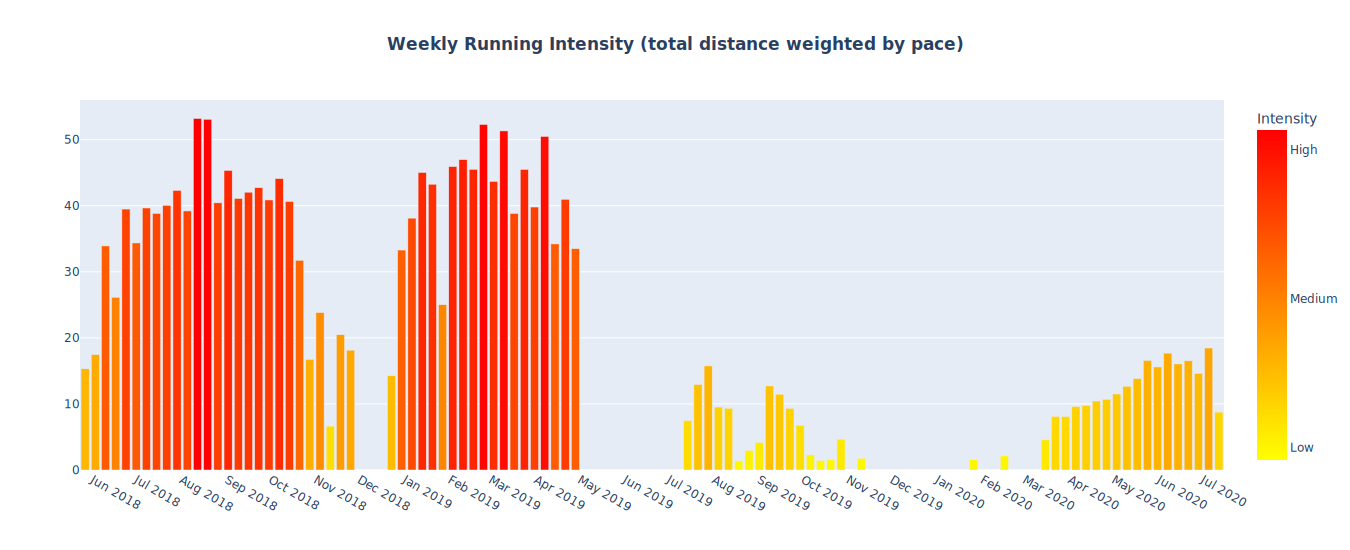

In [78]:
#@title Weekly Running Intensity
fig = px.bar(weekly_intensity, x=weekly_intensity.index, y=weekly_intensity,
                 color=weekly_intensity,
                 title='<b>Weekly Running Intensity (total distance weighted by pace)</b>',
                color_continuous_scale=[(0, 'yellow'), (1, 'red')]
                 )
fig.update_layout(title_x=0.5,
    font_family="Tahoma",
    coloraxis_colorbar=dict(
    title="Intensity",
    tickvals=[2,26,50],
    ticktext=["Low", "Medium", "High"]))
fig.update_xaxes(nticks=28, title_text='')
fig.update_yaxes(title_text='')
fig.show("svg", width=1350, height=550)

We can clearly see peaks in intensity around:
- Mid August 18'
- Feb-March 19'
- Mid April 19'

My guess is that these peaks represent the weeks leading up to races, with the subsequent dips in intensity being a product of Mr. Braun naturally needing to recover.

Moreover, we can see that after his competitive years in college, Mr. Braun never trained at quite the same intensity again.

# A deeper look into periodic fitness and performance




>How do you measure fitness?

Personal records are a great way to gauge when our fitness was at its peak, but they only paint half the picture. In this section we will look at two alternative, subtler ways to measure fitness other than simply measuring how far and how fast we can run.

>Heartrate

Our heartrate naturally rises during exercise as the demand on our cardiovascular system increases. However, as our fitness increases, we are able to perform the same exercise (with the same intensity) with less physical exertion. To put it simply -- if you run regularly and frequently, running becomes easier.

Theoretically, then, our average heartrate should decrease as we become more fit, assuming we run at a similar pace.

>Cadence

Cadence is defined as the number of steps per minute a person takes during a run. Increased cadence has two major benefits: reducing the foot's contact time with the ground, and reducing the risk of injury. Basically, by taking more steps we are: a - taking softer steps which reduce the impact of our foot hitting the ground, and b - spending less time traveling up and down and more time moving in a forward trajectory.

For these reasons, I would expect Mr Braun's average cadence to increase over time as his running technique and fitness improve.


In [79]:
#@title 
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression

def trendline(data):
  """
  Returns a new dataframe containing the original data along with the best line of fit (using linear regression)
  """
  df=pd.DataFrame({'value' : data})
  df = df.reset_index()
  Y=df['value']
  X=df.index
  reg = LinearRegression().fit(np.vstack(X), Y)
  df['bestfit'] = reg.predict(np.vstack(X))
  return df

def comparative_graph(data, titlename, col1, col2, col1_name, col2_name, col1_color='darkseagreen', col2_color='indianred',
                      displayline1=True, displayline2=True, line1_color='green', line2_color='red', range_scale=False):
  """
  Displays a graph comparing weekly averages of two columns
  """
  if range_scale:
    col1_temp = scale_minmax(data.groupby([pd.Grouper(key='Week', freq='W')])[col1].mean().dropna())
    col2_temp = scale_minmax(data.groupby([pd.Grouper(key='Week', freq='W')])[col2].sum().dropna())
  else:
    col1_temp = data.groupby([pd.Grouper(key='Week', freq='W')])[col1].mean().dropna()
    col2_temp = data.groupby([pd.Grouper(key='Week', freq='W')])[col2].mean().dropna()
  col1_trendline=trendline(col1_temp)
  col2_trendline=trendline(col2_temp)

  fig=go.Figure()
  fig.add_trace(go.Bar(name='<b>' + col1_name + '</b>', 
                       x=col1_temp.index,
                       y=col1_temp,
                       marker_color=col1_color))
  fig.add_trace(go.Bar(name='<b>' + col2_name + '</b>',
                       x=col2_temp.index,
                       y=col2_temp,
                       marker_color=col2_color))
  if displayline1:
    fig.add_trace(go.Scatter(name=col1_name + ' Trendline', x=col1_temp.index, y=col1_trendline['bestfit'], mode='lines', opacity=.8, line=dict(color=line1_color, width=5)))
  if displayline2:
    fig.add_trace(go.Scatter(name=col2_name + ' Trendline', x=col2_temp.index, y=col2_trendline['bestfit'], mode='lines', opacity=.8, line=dict(color=line2_color, width=5)))
  fig.update_layout(title=titlename,
                    title_x=0.5,
                    font_family="Tahoma",
                    xaxis_title='Week',
                    yaxis_title='Weekly Averages (scaled)')
  fig.show("svg", width=1350, height=550)

## Does the heartrate slow as fitness increases?

In [80]:
#@title 
import warnings
warnings.filterwarnings('ignore')
pace_vs_hr = data[["Weighted_Pace", "Avg_HR", 'Week']].dropna()

# Scaling HR to 0-1 range
pace_vs_hr["Scaled_HR"] = scale_minmax(pace_vs_hr["Avg_HR"])

pace_vs_hr_0 = pace_vs_hr[:'2018-12-01']
pace_vs_hr_1 = pace_vs_hr['2018-12-01':'2019-06-01']
pace_vs_hr_2 = pace_vs_hr['2019-06-01':'2019-12-01']
pace_vs_hr_3 = pace_vs_hr['2020-03-05':]

Looking at the graphs below we can see that over time the lines representing the average heartrate and average pace **diverge** from eachother. This pattern reoccurs in every one of the four periods, showing us that our heartrate does in fact **decrease** as we become more fit and run more efficiently.

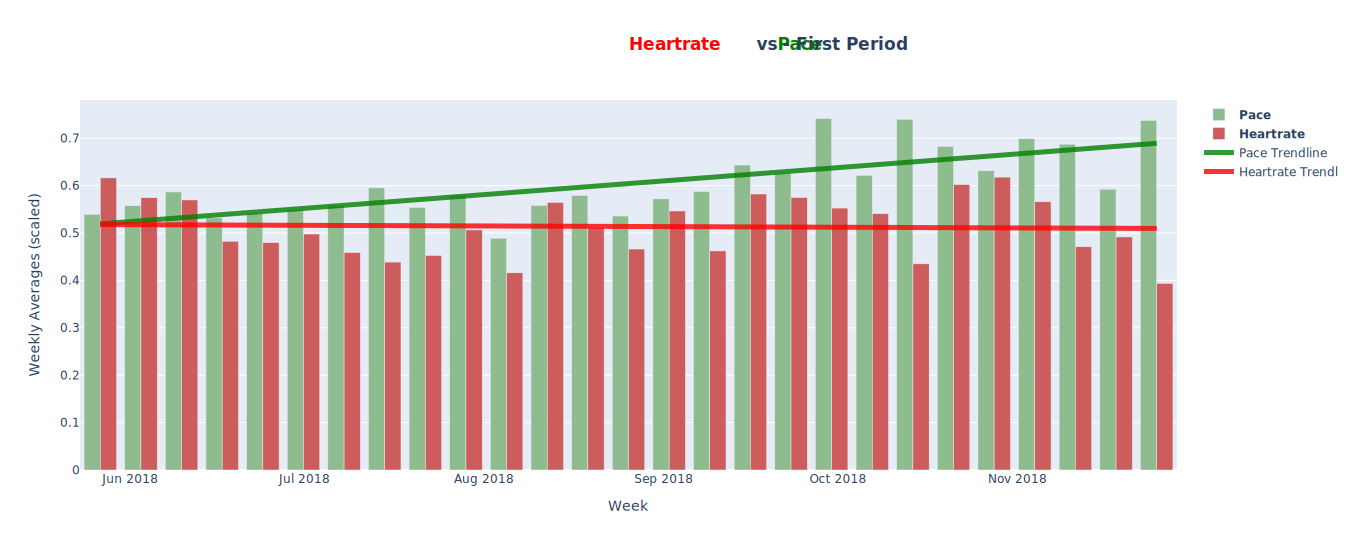

In [81]:
#@title First Period - heartrate stays relatively stable even as pace increases
comparative_graph(pace_vs_hr_0, '<b><span style="color:red">Heartrate</span> vs <span style="color:green">Pace</span> - First Period</b>', 
                  col1='Weighted_Pace', col2='Scaled_HR', col1_name='Pace', col2_name='Heartrate')

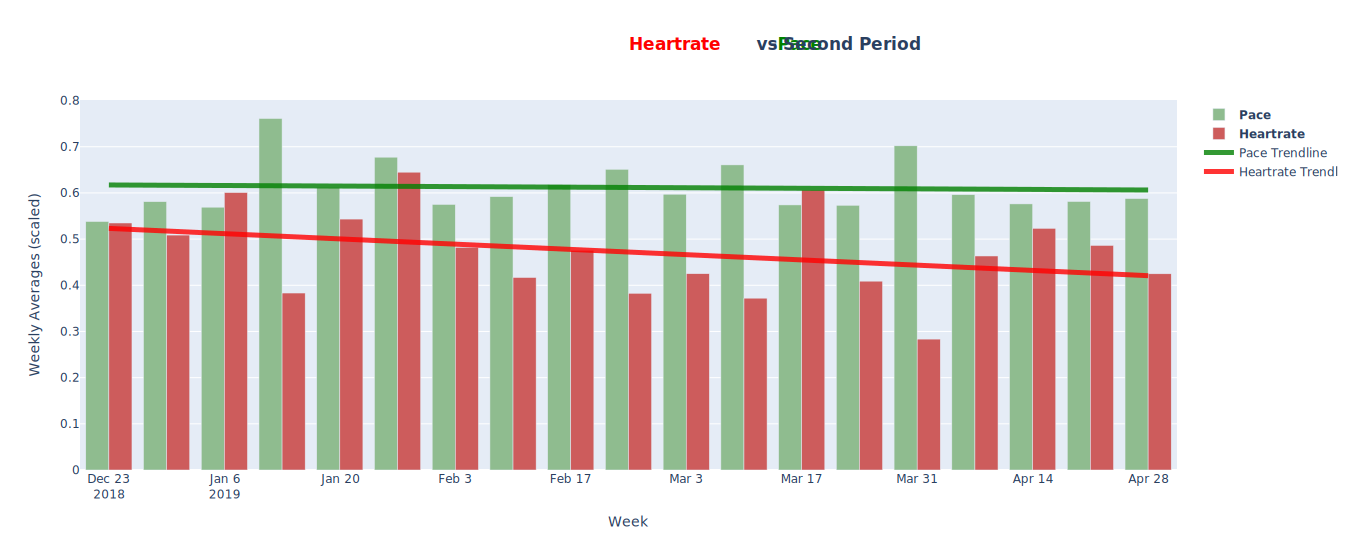

In [82]:
#@title Second Period - heartrate decreases while pace stays relatively stable
comparative_graph(pace_vs_hr_1, '<b><span style="color:red">Heartrate</span> vs <span style="color:green">Pace</span> - Second Period</b>', 
                  col1='Weighted_Pace', col2='Scaled_HR', col1_name='Pace', col2_name='Heartrate')

The third and fourth periods come after Mr. Braun finished his competitive period and took a long break. We can clearly see in the data that he did not pick up in the same place where he left off in terms of fitness.

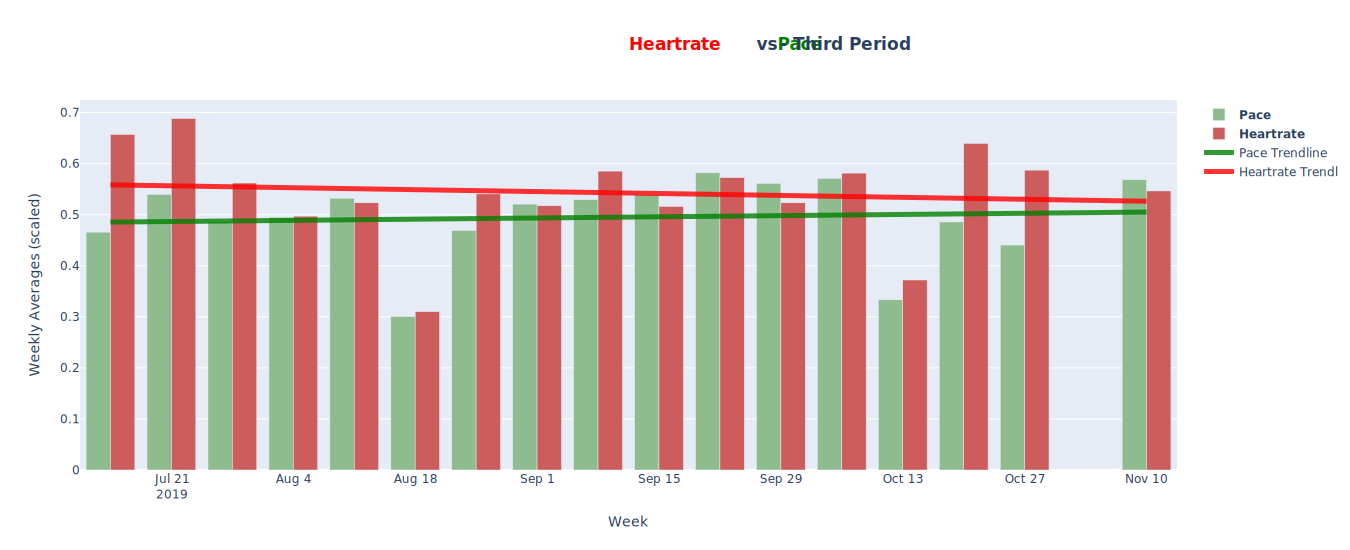

In [83]:
#@title Third Period - heartrate decreases even as pace increases
comparative_graph(pace_vs_hr_2, '<b><span style="color:red">Heartrate</span> vs <span style="color:green">Pace</span> - Third Period</b>', 
                  col1='Weighted_Pace', col2='Scaled_HR', col1_name='Pace', col2_name='Heartrate')

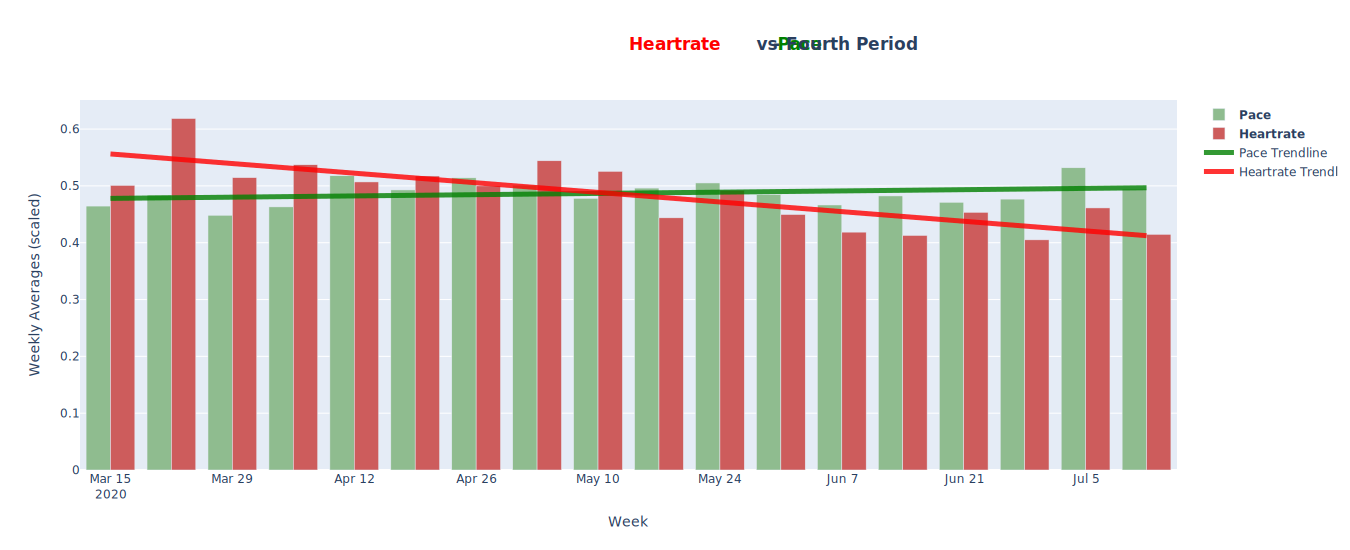

In [84]:
#@title Fourth Period - heartrate decreases while pace slightly increases
comparative_graph(pace_vs_hr_3, '<b><span style="color:red">Heartrate</span> vs <span style="color:green">Pace</span> - Fourth Period</b>', 
                  col1='Weighted_Pace', col2='Scaled_HR', col1_name='Pace', col2_name='Heartrate')

## Is higher cadence a sign of better running technique and fitness?

In [85]:
#@title 
cadence = data[['Week', 'Avg_Run_Cadence']].dropna()

cadence_0 = cadence[:'2018-12-01']
cadence_1 = cadence['2018-12-01':'2019-06-01']
cadence_2 = cadence['2019-06-01':'2019-12-01']
cadence_3 = cadence['2020-03-14':]

In [86]:
#@title 
def single_graph(data, titlename, col, col_name):
  """
  Displays a graph comparing weekly averages of two columns
  """
  col_temp = data.groupby([pd.Grouper(key='Week', freq='W')])[col].mean().dropna()
  col_trendline=trendline(col_temp)

  fig=go.Figure()
  fig.add_trace(go.Bar(name='<b>' + col_name + '</b>', 
                       x=col_temp.index,
                       y=col_temp,
                       marker_color='lightslategray'))
  fig.add_trace(go.Scatter(name=col_name + ' Trendline', x=col_temp.index, y=col_trendline['bestfit'], 
                        mode='lines', opacity=.8, line=dict(color='darkslategray', width=4, dash='solid')))
  fig.update_layout(title=titlename,
                    title_x=0.5,
                    font_family="Tahoma",
                    xaxis_title='Week',
                    yaxis_title='Weekly Average',
                    yaxis_range=[col_temp.min() - 7, col_temp.max() + 1]
                    )
  fig.show("svg", width=1350, height=550)

The graphs below show us that Mr. Braun's cadence **increases** within each period. 

The biggest improvement is seen in the first period as Mr. Braun reaches 180 SPM (steps per minute) which is considered a good standard for competitive runners. 

In the second period he hovers around this same 180 mark. 

The third and fourth periods showcase a lower average cadence (Mr. Braun was no longer running competitively). However, we still see a periodic trend of improvement.



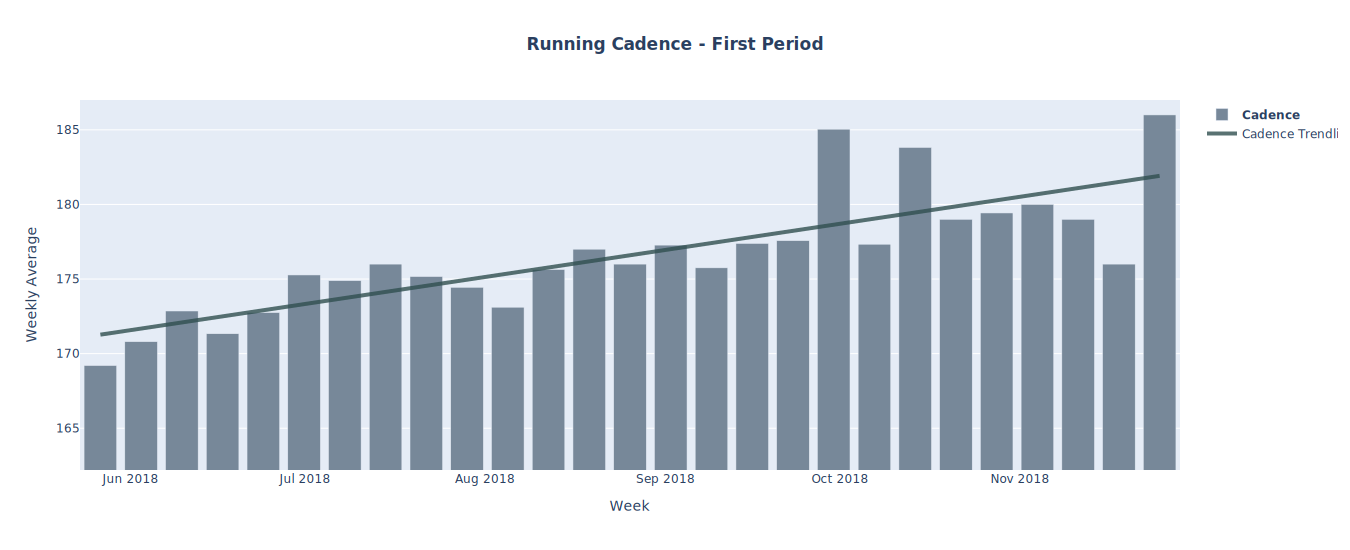

In [87]:
#@title Running Cadence - First Period
single_graph(cadence_0, '<b>Running Cadence - First Period</b>', 
                     col='Avg_Run_Cadence', col_name='Cadence')

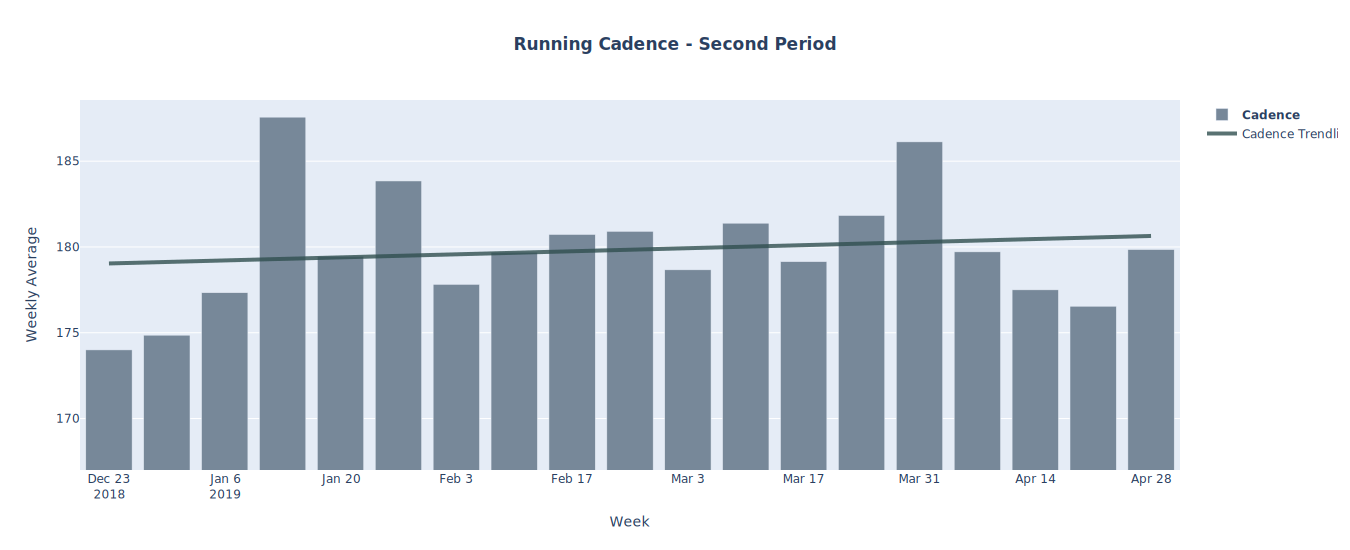

In [88]:
#@title Running Cadence - Second Period
single_graph(cadence_1, '<b>Running Cadence - Second Period</b>', 
                     col='Avg_Run_Cadence', col_name='Cadence')

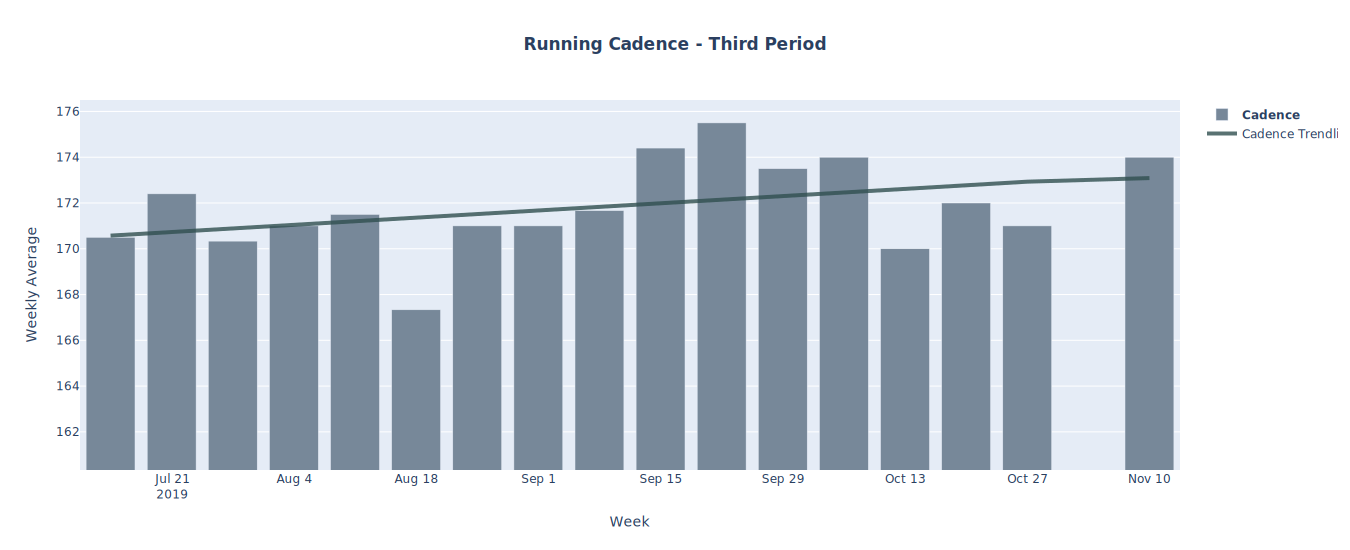

In [89]:
#@title Running Cadence - Third Period
single_graph(cadence_2, '<b>Running Cadence - Third Period</b>', 
                     col='Avg_Run_Cadence', col_name='Cadence')

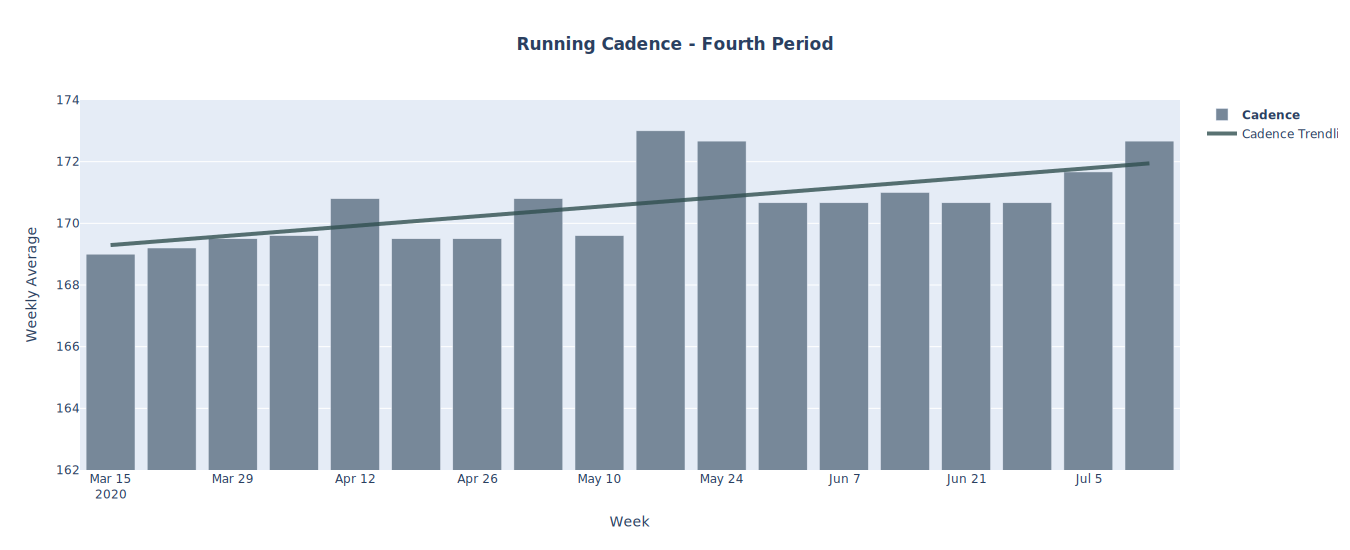

In [90]:
#@title Running Cadence - Fourth Period
single_graph(cadence_3, '<b>Running Cadence - Fourth Period</b>', 
                     col='Avg_Run_Cadence', col_name='Cadence')

In summary, we see that as Mr. Braun trains consistently, his average cadence increases and his average heartrate decreases. The keyword here being **consistency**; we see drops in performance following prolonged breaks from running.

## So how do we estimate fitness?

In the sections above we saw that consistent training leads to decreased heartrate (while running at a given pace) and increased cadence. Additionally, we expect a runner's overall capacity to increase as he becomes more fit, meaning he is able to run further and faster than before.

In my attempt to estimate overall "fitness" - I combined a few variables to create a new variable called *Fitness_Level*. The variable is comprised of three positive weights and one negative weight:
- **Intensity** - represents an overall capacity; the total distance covered weighted by the pace at which it was done.
- **Pace** - even though he may choose to run faster or slower, we expect Mr. Braun's average pace to increase over time as he gets better and better at running.
- **Cadence** - while this is partly about technique, higher levels of fitness allow an athlete to run at a higher cadence while maintaining an equal or better pace.
- **Heartrate** - represented by a negative value, because a higher heartrate means a lower level of fitness (or an increased pace, but in that case it'll be balanced out by the *Pace* weight).

In [91]:
#@title 
fitness = data[['Week', 'Avg_Run_Cadence', 'Avg_HR', 'Weighted_Pace', 'Intensity']].dropna()

# Scaling variables to 0-1 range
fitness["Scaled_Cadence"] = scale_minmax(fitness["Avg_Run_Cadence"])
fitness["Scaled_HR"] = scale_minmax(fitness["Avg_HR"])
fitness["Scaled_Intensity"] = scale_minmax(fitness["Intensity"])

# Intensity + Pace + Cadence - Heartrate
fitness["Fitness_Level"] = fitness["Scaled_Intensity"] + fitness["Weighted_Pace"] + fitness["Scaled_Cadence"] - fitness["Scaled_HR"]

fitness_0 = fitness[:'2018-12-01']
fitness_1 = fitness['2018-12-01':'2019-06-01']
fitness_2 = fitness['2019-06-01':'2019-12-01']
fitness_3 = fitness['2020-03-05':]

Below is a plot of the *Fitness_Level* over time, in addition to two lines marking PRs (Personal Records).

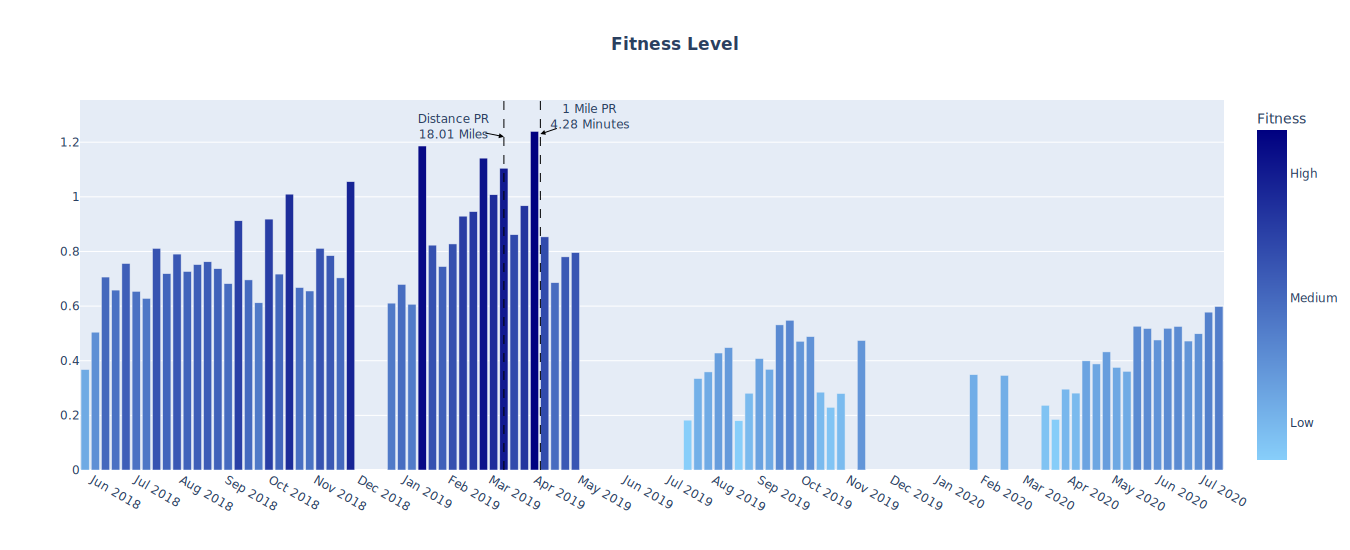

In [92]:
#@title Fitness Level with PRs (personal records)
Fitness_Level = fitness.groupby([pd.Grouper(key='Week', freq='W')])['Fitness_Level'].mean().dropna()

fig=go.Figure()
fig.add_trace(go.Bar(name='<b>Fitness Level</b>', 
              x=Fitness_Level.index,
              y=Fitness_Level,
              marker_color='royalblue'))

fig = px.bar(Fitness_Level, x=Fitness_Level.index, y=Fitness_Level,
                 color=Fitness_Level,
                 title='<b>Fitness Level</b>',
                color_continuous_scale=[(0, 'lightskyblue'), (1, 'navy')]
                 )
fig.update_xaxes(nticks=28, title_text='')
fig.update_yaxes(title_text='')
fig.update_layout(title_x=0.5,
    font_family="Tahoma",
    coloraxis_colorbar=dict(
    title="Fitness",
    tickvals=[0.3,0.7,1.1],
    ticktext=["Low", "Medium", "High"]))
fig.add_annotation(
    x='2019-03-10',
    y=1.22, 
    text=f'Distance PR<br>18.01 Miles', 
    showarrow=True, 
    arrowhead=2, 
    arrowsize=1, 
    arrowwidth=1, 
    arrowcolor="black", 
    ax=-50, 
    ay=-10
    )
fig.add_vline(x='2019-03-10', line_width=1, line_color="black", line_dash='dash')
fig.add_annotation(
    x='2019-04-04',
    y=1.23, 
    text=f'1 Mile PR<br>4.28 Minutes', 
    showarrow=True, 
    arrowhead=2, 
    arrowsize=1, 
    arrowwidth=1, 
    arrowcolor="black", 
    ax=50, 
    ay=-17
    )
fig.add_vline(x='2019-04-04', line_width=1, line_color="black", line_dash='dash')
fig.show("svg", width=1350, height=550)

Under the assumption that fitness should increase as a result of consistent training, this graph seems like a decently accurate approximation of fitness. For one, both PRs were achieved in close proximity to fitness peaks.

Additionally, while the graph is nowhere near being linear -- it does reflect a gradual increase in fitness within each period of training. Anyway, it would be wrong to expect the progress to be linear due to the nature of the training and recovery cycle, in addition to many other factors which cannot be accounted for and which may negatively impact performance in a given week.

## Intensity vs Fitness

Interestingly, it seems that higher training intensity does not directly translate to higher levels of fitness. I think this is due to the need for adequate recovery following intense training.

To illustrate the matter - I put the fitness level plot from above and the intensity plot from an eariler section side by side while looking at each period individually.

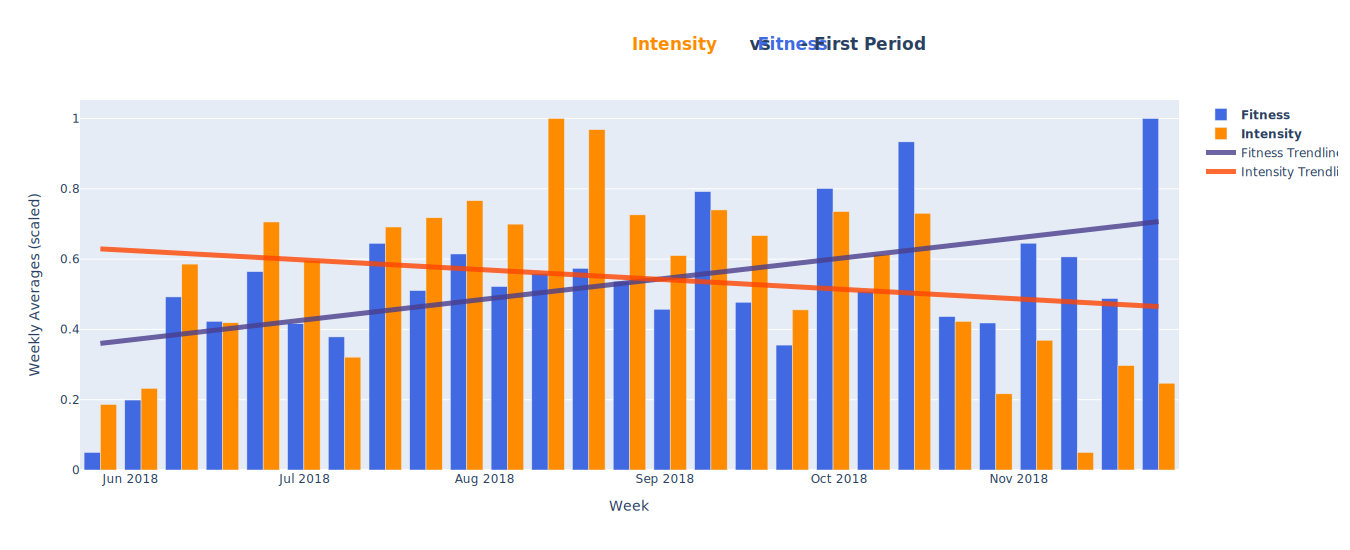

In [93]:
#@title First Period - intensity rises then tapers off while fitness steadily increases
comparative_graph(fitness_0, '<b><span style="color:darkorange">Intensity</span> vs <span style="color:royalblue">Fitness</span> - First Period</b>', 
                  col2='Intensity', col1='Fitness_Level', col2_name='Intensity', col1_name='Fitness',
                  col1_color='royalblue', col2_color='darkorange',
                  line1_color='darkslateblue', line2_color='orangered', range_scale=True)

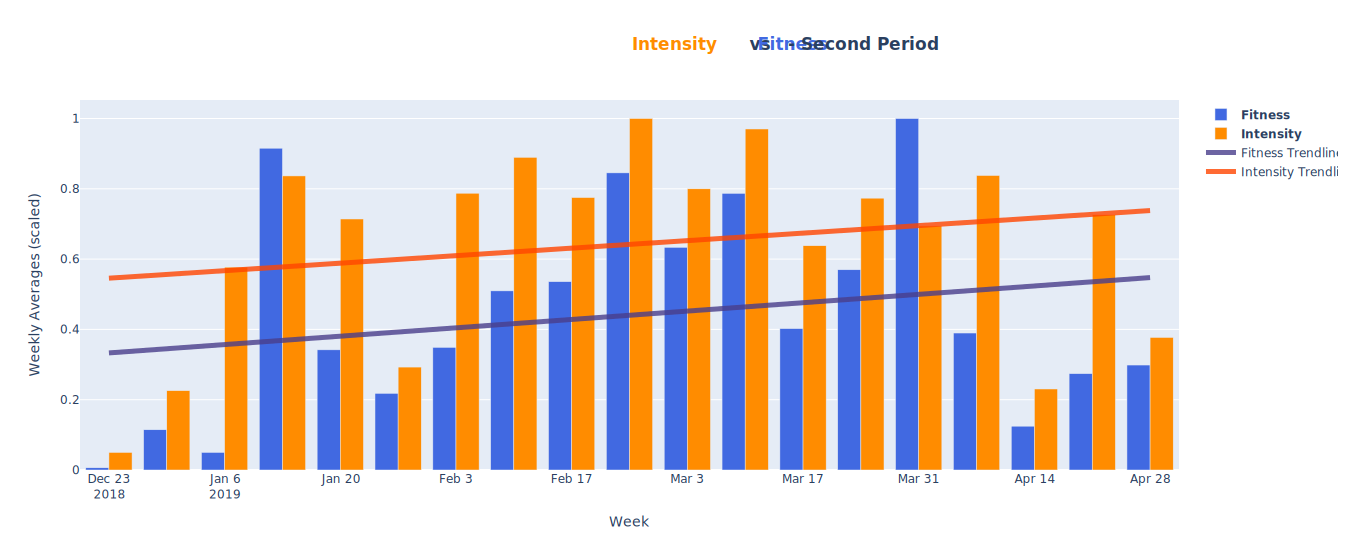

In [94]:
#@title Second Period - both intensity and fitness seem to slightly increase
comparative_graph(fitness_1, '<b><span style="color:darkorange">Intensity</span> vs <span style="color:royalblue">Fitness</span> - Second Period</b>', 
                  col2='Intensity', col1='Fitness_Level', col2_name='Intensity', col1_name='Fitness',
                  col1_color='royalblue', col2_color='darkorange', line1_color='darkslateblue', line2_color='orangered', range_scale=True)

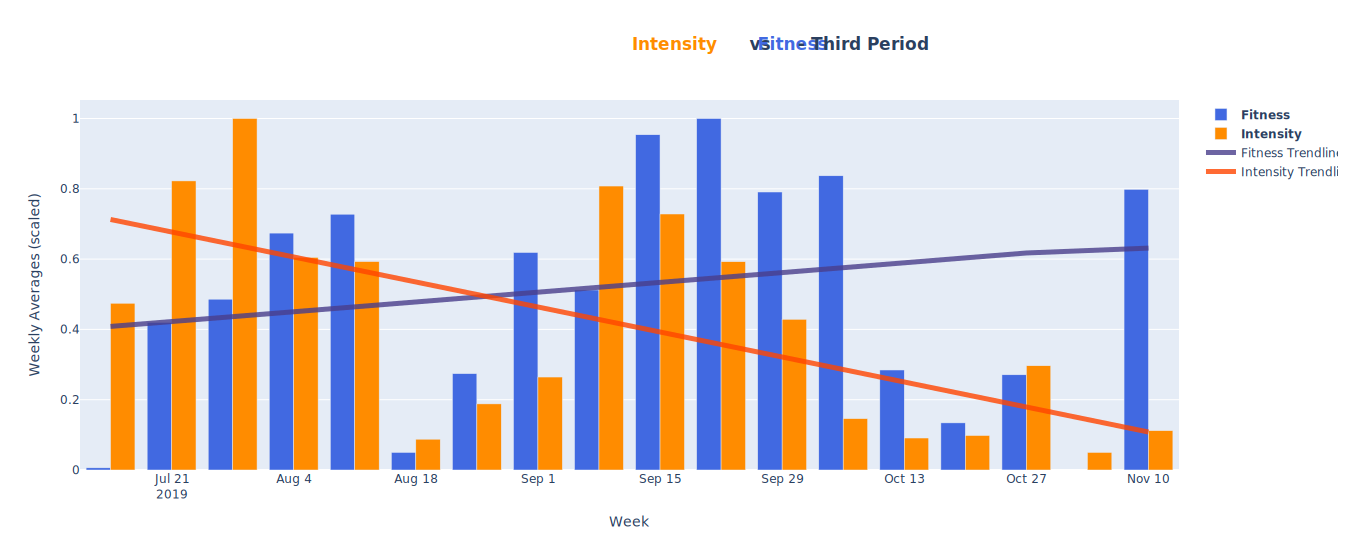

In [95]:
#@title Third Period - following a long break, intensity and fitness seem to have an almost inverse relationship
comparative_graph(fitness_2, '<b><span style="color:darkorange">Intensity</span> vs <span style="color:royalblue">Fitness</span> - Third Period</b>', 
                  col2='Intensity', col1='Fitness_Level', col2_name='Intensity', col1_name='Fitness',
                  col1_color='royalblue', col2_color='darkorange', line1_color='darkslateblue', line2_color='orangered', range_scale=True)

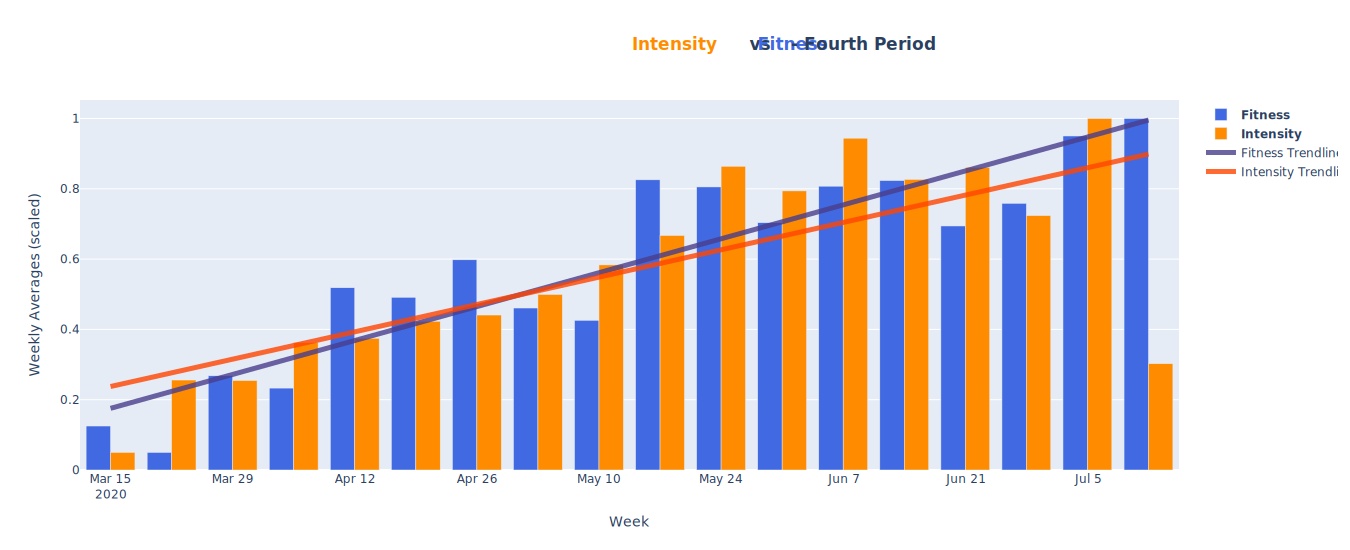

In [96]:
#@title Fourth Period - progressively increasing intensity and fitness. In the last week fitness rises even as intensity dips.
comparative_graph(fitness_3, '<b><span style="color:darkorange">Intensity</span> vs <span style="color:royalblue">Fitness</span> - Fourth Period</b>', 
                  col2='Intensity', col1='Fitness_Level', col2_name='Intensity', col1_name='Fitness',
                  col1_color='royalblue', col2_color='darkorange', line1_color='darkslateblue', line2_color='orangered', range_scale=True)

Looking at the graphs above, we see that the fitness level steadily increases over time even as the level of intensity varies. This goes to show that the key to becoming more fit is first and foremost consistency, and that often reducing training intensity is what allows us to properly recover and perform our best.